In [31]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/github.com/ucla-biostat-216/2023fall/slides/14-app`


Status `~/Documents/github.com/ucla-biostat-216/2023fall/slides/14-app/Project.toml`
  [1e616198] COSMO v0.8.8
  [13f3f980] CairoMakie v0.11.2
  [f65535da] Convex v0.15.4
  [31c24e10] Distributions v0.25.103
  [ced4e74d] DistributionsAD v0.6.53
  [5789e2e9] FileIO v1.16.1
  [f6369f11] ForwardDiff v0.10.36
  [916415d5] Images v0.26.0
  [ee78f7c6] Makie v0.20.2
  [90014a1f] PDMats v0.11.30
  [0c5d862f] Symbolics v5.10.0
  [e88e6eb3] Zygote v0.6.67


## Matrix completion

* Snapshot of the kind of data collected by Netflix. Only 100,480,507 ratings (1.2% entries of the 480K-by-18K matrix) are observed

<img src="./netflix_matrix.png" width="500" align="center"/>

* Netflix challenge: impute the unobserved ratings for personalized recommendation.
http://en.wikipedia.org/wiki/Netflix_Prize

<img src="./netflix_prize.png" width="500" align="center"/>

* **Matrix completion problem**. Observe a very sparse matrix $\mathbf{Y} = (y_{ij})$. Want to impute all the missing entries. It is possible only when the matrix is structured, e.g., of _low rank_.

* Example: Load the 128×128 Lena picture with missing pixels.

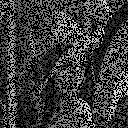

In [32]:
using FileIO, Images

lena = load("lena128missing.png")

In [33]:
# convert to real matrices
Y = Float64.(lena)

128×128 Matrix{Float64}:
 0.0       0.0       0.635294  0.0       …  0.0       0.0       0.627451
 0.627451  0.623529  0.0       0.611765     0.0       0.0       0.388235
 0.611765  0.611765  0.0       0.0          0.403922  0.219608  0.0
 0.0       0.0       0.611765  0.0          0.223529  0.176471  0.192157
 0.611765  0.0       0.615686  0.615686     0.0       0.0       0.0
 0.0       0.0       0.0       0.619608  …  0.0       0.0       0.2
 0.607843  0.0       0.623529  0.0          0.176471  0.192157  0.0
 0.0       0.0       0.623529  0.0          0.0       0.0       0.215686
 0.619608  0.619608  0.0       0.0          0.2       0.0       0.207843
 0.0       0.0       0.635294  0.635294     0.2       0.192157  0.188235
 ⋮                                       ⋱  ⋮                   
 0.345098  0.341176  0.356863  0.513725     0.0       0.0       0.231373
 0.0       0.0       0.0       0.0       …  0.0       0.243137  0.258824
 0.298039  0.415686  0.458824  0.0          0.0       

We fill out the missing pixels uisng a **matrix completion** technique developed by Candes and Tao
$$
    \text{minimize } \|\mathbf{X}\|_*
$$
$$
    \text{subject to } x_{ij} = y_{ij} \text{ for all observed entries } (i, j).
$$
Here $\|\mathbf{M}\|_* = \sum_i \sigma_i(\mathbf{M})$ is the nuclear norm. In words we seek the matrix with minimal nuclear norm that agrees with the observed entries. This is a semidefinite programming (SDP) problem readily solved by modern convex optimization software.

We use the convex optimizaion package COSMO.jl to solve for this semi-definite program.

In [34]:
# # Use COSMO solver
using Convex, COSMO
solver = COSMO.Optimizer()

# Linear indices of obs. entries
obsidx = findall(Y[:] .≠ 0.0)
# Create optimization variables
X = Variable(size(Y))
# Set up optmization problem
problem = minimize(nuclearnorm(X))
problem.constraints += X[obsidx] == Y[obsidx]
# Solve the problem by calling solve
@time solve!(problem, solver) # fast

------------------------------------------------------------------
          COSMO v0.8.8 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{49153},
          constraints: A ∈ R^{73665x49153} (73793 nnz),
          matrix size to factor: 122818x122818,
          Floating-point precision: Float64
Sets:     ZeroSet of dim: 40769
          DensePsdConeTriangle of dim: 32896 (256x256)
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 3

50	 1.4754e+02	1.2369e-02	1.6744e-03	7.4179e-01
75	 1.4797e+02	4.9490e-04	5.5696e-05	7.4179e-01


100	 1.4797e+02	1.4115e-05	1.3438e-06	7.4179e-01

------------------------------------------------------------------
>>> Results
Status: Solved
Iterations: 100
Optimal objective: 148
Runtime: 0.857s (856.75ms)

  1.242270 seconds (1.73 M allocations: 675.980 MiB, 5.35% gc time, 26.32% compilation time: 97% of which was recompilation)


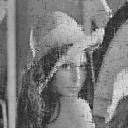

In [35]:
colorview(Gray, X.value)

## Compressed sensing

* **Compressed sensing** [Candes and Tao (2006)](https://doi.org/10.1109/TIT.2006.885507) and [Donoho (2006)](https://doi.org/10.1109/TIT.2006.871582) tries to address a fundamental question: how to compress and transmit a complex signal (e.g., musical clips, mega-pixel images), which can be decoded to recover the original signal?

<img src="./david-donoho.jpg" width="100"/>
<img src="./emmanuel-candes.png" width="100"/>
<img src="./terrence-tao.png" width="100"/>

* Suppose a signal $\mathbf{x} \in \mathbb{R}^n$ is sparse with $s$ non-zeros. We under-sample the signal by multiplying a (flat) measurement matrix $\mathbf{y} = \mathbf{A} \mathbf{x}$, where $\mathbf{A} \in \mathbb{R}^{m\times n}$ has iid normal entries. [Candes, Romberg and Tao (2006)](https://doi.org/10.1002/cpa.20124) show that the solution to
$$
\begin{eqnarray*}
	&\text{minimize}& \|\mathbf{x}\|_1 \\
	&\text{subject to}& \mathbf{A} \mathbf{x} = \mathbf{y}
\end{eqnarray*}
$$
exactly recovers the true signal under certain conditions on $\mathbf{A}$ when $n \gg s$ and $m \approx s \ln(n/s)$. Why sparsity is a reasonable assumption? _Virtually all real-world images have low information content_.

<img src="./movie-scene.png" width="400"/>

Generate a sparse signal and sub-sampling:

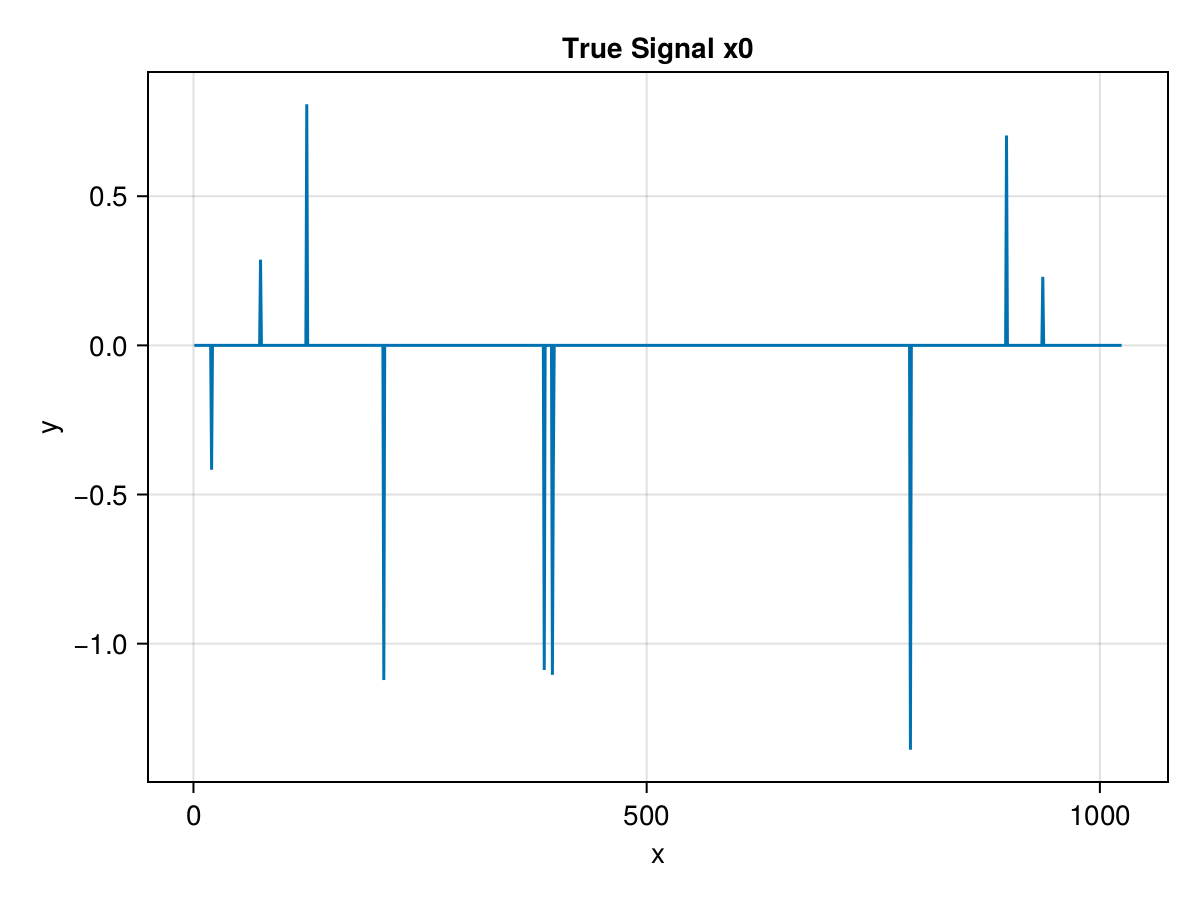

In [36]:
using CairoMakie, Makie, Random

# random seed
Random.seed!(123)
# Size of signal
n = 1024
# Sparsity (# nonzeros) in the signal
s = 10
# Number of samples (undersample by a factor of 8) 
m = 128

# Generate and display the signal
x0 = zeros(n)
x0[rand(1:n, s)] = randn(s)
# Generate the random sampling matrix
A = randn(m, n) / m
# Subsample by multiplexing
y = A * x0

# plot the true signal
f = Figure()
Makie.Axis(
    f[1, 1], 
    title = "True Signal x0",
    xlabel = "x",
    ylabel = "y"
)
lines!(1:n, x0)
f

Solve the linear programming problem.

In [37]:
# Use COSMO solver
solver = COSMO.Optimizer()
# MOI.set(solver, MOI.RawOptimizerAttribute("max_iter"), 5000)

# Set up optimizaiton problem
x = Variable(n)
problem = minimize(norm(x, 1))
problem.constraints += A * x == y

# Solve the problem
@time solve!(problem, solver)

------------------------------------------------------------------
          COSMO v0.8.8 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{2049},
          constraints: A ∈ R^{2177x2049} (136193 nnz),
          matrix size to factor: 4226x4226,
          Floating-point precision: Float64
Sets:     Nonnegatives of dim: 2048
          ZeroSet of dim: 129
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safeguarded: true, tol: 2.0
Setup Time: 12.68ms

Iter:	Objective:	Pr

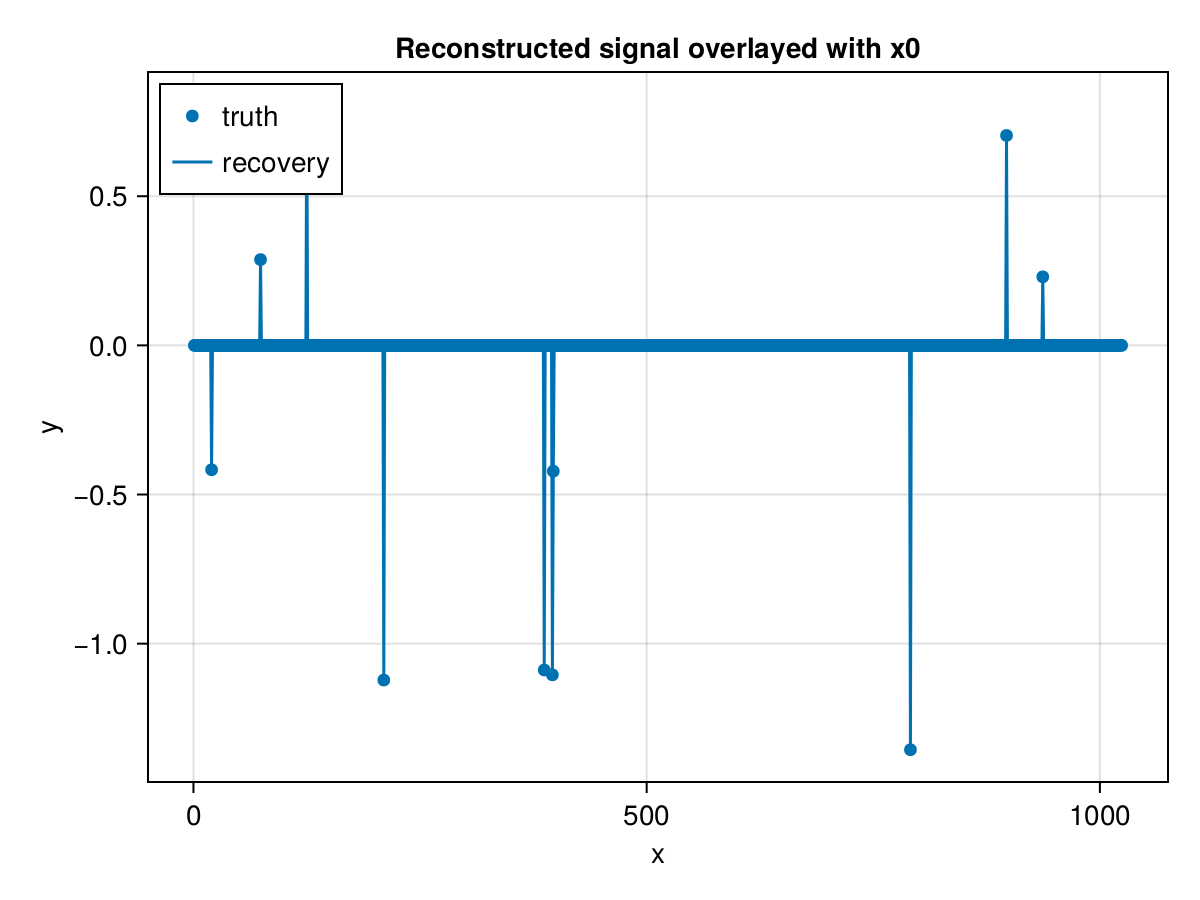

In [38]:
# Display the solution
f = Figure()
Makie.Axis(
    f[1, 1], 
    title = "Reconstructed signal overlayed with x0",
    xlabel = "x",
    ylabel = "y"
)
scatter!(1:n, x0, label = "truth")
lines!(1:n, vec(x.value), label = "recovery")
axislegend(position = :lt)
f

## Automatic differentiation (Auto-Diff)

Last week we scratched the surface of matrix/vector calculus and chain rules. Recent surge of machine learning sparked rapid advancement of automatic differentiation, which applies chain rule to the computer code to obtain exact gradients (up to machine precision).

### Example: multivariate normal

Define log-likelihood function.

In [39]:
using Distributions, DistributionsAD, LinearAlgebra, PDMats, Random, Zygote

Random.seed!(216)
n, p = 100, 3
Y = randn(p, n) # each column of Y is a sample


3×100 Matrix{Float64}:
  1.27293     0.45854    0.881297  …  -0.386115  -0.552413   0.154779
 -0.0716618   0.100877  -1.5708        0.866487  -0.434057   0.0726842
 -0.445158   -1.24595    0.485928     -1.25812   -0.675163  -0.882397

In [40]:
# log-likelihood evaluator
mnlogl = (θ) -> loglikelihood(MvNormal(θ[:μ], θ[:Ω]), Y)

#21 (generic function with 1 method)

In [41]:
# log-likelihood at (μ = 0, Ω = I)
θ = (μ = zeros(p), Ω = Matrix{Float64}(I(p)))
mnlogl(θ)

-442.06153771100463

Calculate gradient by auto-diff.

In [42]:
# gradient of log-likeliohod at (μ = 0, Ω = I)
θ̄ = Zygote.gradient(mnlogl, θ)[1];

In [43]:
θ̄[:μ]

3-element Vector{Float64}:
   0.28541706942228096
  -5.239342603555363
 -29.58708211691224

In [44]:
θ̄[:Ω]

3×3 UpperTriangular{Float64, Matrix{Float64}}:
 2.54102   1.8363  -3.40248
  ⋅       10.3971   4.94345
  ⋅         ⋅       3.44186

Let us check whether auto-diff yields the same answer as our analytical derivations.

In [45]:
# analytical gradient dL/dμ = Ω^{-1} ∑ᵢ (yᵢ - μ)
θ̄[:μ] ≈ θ[:Ω] \ sum(Y .- θ[:μ], dims = 2)

true

In [46]:
# analytical gradient dL/dΩ = -n/2 Ω^{-1} + 1/2 Ω^{-1} ∑ᵢ (yᵢ - μ)(yᵢ - μ)' Ω^{-1}
θ̄[:Ω] ≈ - (n/2) * inv(θ[:Ω]) + 0.5 * inv(θ[:Ω]) * ((Y .- θ[:μ]) * (Y .- θ[:μ])') * inv(θ[:Ω])

false

Surprise! Gradients of the covariance matrix do not match. Close inspection reveals that Julia calculates the gradient with respect to the upper triangular part of the covariance matrix $\text{vech}(\Omega)$

In [47]:
# gradient with respect to vech(Ω)
θ̄[:Ω]

3×3 UpperTriangular{Float64, Matrix{Float64}}:
 2.54102   1.8363  -3.40248
  ⋅       10.3971   4.94345
  ⋅         ⋅       3.44186

In [48]:
# gradient wrt vec(Ω)
- (n/2) * inv(θ[:Ω]) + 0.5 * inv(θ[:Ω]) * ((Y .- θ[:μ]) * (Y .- θ[:μ])') * inv(θ[:Ω])

3×3 Matrix{Float64}:
  2.54102    0.918151  -1.70124
  0.918151  10.3971     2.47172
 -1.70124    2.47172    3.44186

### Example: factor analysis

Now let's try the more complicated factor analysis, where $\boldsymbol{\Omega} = \mathbf{F} \mathbf{F}' + \mathbf{D}$.

In [49]:
# log-likelihood evaluator
falogl = (θ) -> loglikelihood(MvNormal(θ[:F] * θ[:F]' + diagm(θ[:d])), Y)

#23 (generic function with 1 method)

In [50]:
r = 2
# log-likelihood at (F = ones(p, 2), d = ones(p))
θ = (F = ones(p, r), d = ones(p))
falogl(θ)

-490.85497606101296

In [51]:
# gradient of log-likeliohod at (F = ones(p, 2), d = ones(p))
θ̄ = Zygote.gradient(falogl, θ)[1];

In [52]:
# auto-diff gradient wrt F
θ̄[:F]

3×2 Matrix{Float64}:
 -13.3555  -13.3555
  -9.9186   -9.9186
 -12.6542  -12.6542

In [53]:
# analytic gradient wrt F
Ω = θ[:F] * θ[:F]' + diagm(θ[:d])
S = Y * Y' / n
- n * inv(Ω) * θ[:F] + n * inv(Ω) * S * inv(Ω) * θ[:F]

3×2 Matrix{Float64}:
 -13.3555  -13.3555
  -9.9186   -9.9186
 -12.6542  -12.6542

In [54]:
# auto-diff gradient wrt d
θ̄[:d]

3-element Vector{Float64}:
 1.1085074611630732
 2.0908476672040432
 0.606829360941255

In [55]:
# analytic gradient wrt d
- (n / 2) * diag(inv(Ω) -  inv(Ω) * S * inv(Ω))

3-element Vector{Float64}:
 1.1085074611630608
 2.090847667204021
 0.6068293609412523

Hessian (second derivatives) is essentially gradient of gradient. ForwardDiff.jl is better for Hessian calculation.

In [56]:
using ForwardDiff

# HFF = ∂²L/∂F∂F'
ForwardDiff.jacobian(F -> Zygote.gradient(falogl, (F = F, d = ones(p)))[1][:F], θ[:F])

6×6 Matrix{Float64}:
 -1.90729   -1.25196   -0.728345  -4.12431    6.65049    6.94168
 -1.25196   -1.76658   -0.378075   6.65049   -5.94828    5.81976
 -0.728345  -0.378075  -2.681      6.94168    5.81976   -3.89466
 -4.12431    6.65049    6.94168   -1.90729   -1.25196   -0.728345
  6.65049   -5.94828    5.81976   -1.25196   -1.76658   -0.378075
  6.94168    5.81976   -3.89466   -0.728345  -0.378075  -2.681

In [57]:
# Hdd = ∂²L/∂d∂d'
ForwardDiff.jacobian(d -> Zygote.gradient(falogl, (F = θ[:F], d = d))[1][:d], θ[:d])

3×3 Matrix{Float64}:
 -27.0938    -6.33948   -6.27307
  -6.33948  -28.4971    -5.85244
  -6.27307   -5.85244  -26.3771

In [58]:
# Hθθ = ∂²L/∂θ∂θ'

# gradient function with vector input and vector output
falogl_grad = function(θvec)
    θ = (F = reshape(θvec[1:(p * r)], p, r), d = θvec[(p * r + 1):(p * r + p)])
    θ̄ = Zygote.gradient(falogl, θ)[1]
    return [vec(θ̄[:F]); vec(θ̄[:d])]
end

ForwardDiff.jacobian(falogl_grad, [vec(θ[:F]); vec(θ[:d])])

9×9 Matrix{Float64}:
 -1.90729   -1.25196   -0.728345  …   -0.981177    2.37667    1.56186
 -1.25196   -1.76658   -0.378075       1.39471    -3.71675    1.35155
 -0.728345  -0.378075  -2.681          1.3615      2.13315   -1.33874
 -4.12431    6.65049    6.94168       -0.981177    2.37667    1.56186
  6.65049   -5.94828    5.81976        1.39471    -3.71675    1.35155
  6.94168    5.81976   -3.89466   …    1.3615      2.13315   -1.33874
 -0.981177   1.39471    1.3615       -27.0938     -6.33948   -6.27307
  2.37667   -3.71675    2.13315       -6.33948   -28.4971    -5.85244
  1.56186    1.35155   -1.33874       -6.27307    -5.85244  -26.3771